In [1]:
import h5py, time
import click
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path

from filelock import FileLock
import json

import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy.stats import spearmanr
import sh
import wandb
import yaml

from tfomics import moana, impress

import model_zoo, utils

# set seed for reproducibility
np.random.seed(0)

2023-05-09 12:58:39.498600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 12:58:39.612709: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 12:58:40.269923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64:
2023-05-09 12:58:40.270007: W te

In [99]:
importlib.reload(utils)

<module 'utils' from '/home/chandana/projects/hominid_pipeline/utils.py'>

# Load model

In [105]:
params_paths = [
    "/home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00193_193_conv1_activation=relu,conv1_attention_pool_size=10,conv1_batchnorm=False,conv1_channel_weight=se,conv_2023-05-05_06-53-12",
    "/home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00011_11_conv1_activation=relu,conv1_attention_pool_size=32,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-04_16-39-12",
    "/home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00187_187_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-05_06-23-16"
]

In [120]:
params_path = params_paths[0]
config = json.load(open(f"{params_path}/params.json"))
weights_path = f"{params_path}/weights"

config = json.load(open(f"{params_path}/params.json"))
_, _, _, _, x_test, y_test, model = utils.hominid_pipeline(config)

model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
    )
print(model.summary())

model.load_weights(f'{params_path}/weights')

Input shape: (402296, 249, 4). Output shape: 2
2
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 512)    937472      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_activation (Activation)  (None, 249, 512)     0           ['pairwise_conv1d[0][0]']        
                                                                                                  
 se_pool (GlobalAveragePooling1  (None, 512)         0           ['conv1_activation[0][0]']   

                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,061,314
Trainable params: 3,059,266
Non-trainable params: 2,048
__________________________________________________________________________________________________
None


# Evaluate model

In [117]:
# run for each set and enhancer type
utils.evaluate_model(model, x_test,  y_test, "Dev")
utils.evaluate_model(model, x_test,  y_test, "Hk")

81/81 [==============================] - 8s 81ms/step
Dev MSE = 1.236
Dev PCC = 0.687
Dev SCC = 0.656
81/81 [==============================] - 6s 80ms/step
Hk MSE = 1.164
Hk PCC = 0.774
Hk SCC = 0.592


(1.164151, 0.7737614218767399, 0.5918300823845792)

# Interpret filters

Loading filters...
Plotting filters...


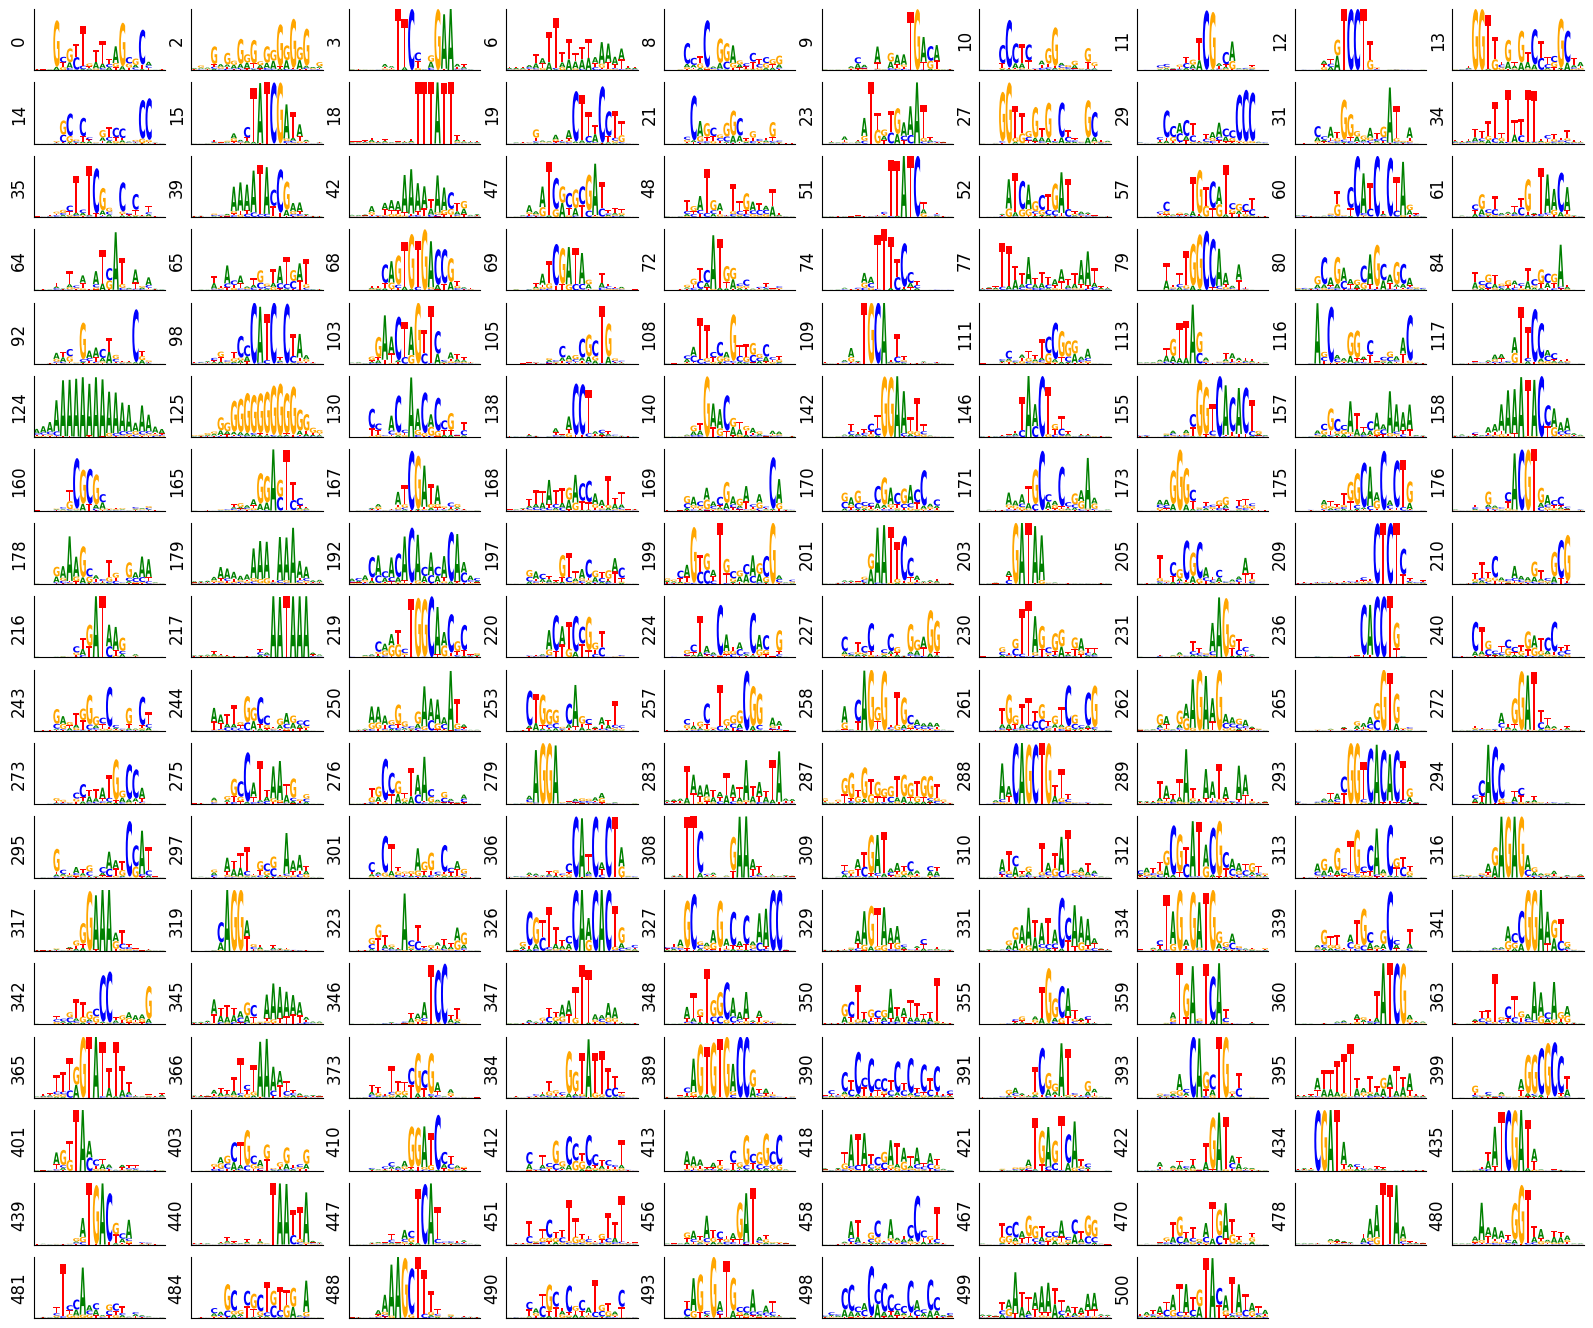

In [121]:
# Usage example
layer = 2
threshold = 0.5
window = 20

W, counts = utils.calculate_filter_activations(
                    model, 
                    x_test, 
                    params_path,
                    layer, 
                    threshold, 
                    window, 
                    batch_size=64, 
                    plot_filters=True,
                    from_saved=True
                )

# sh.cp("-r", params_path, "/home/chandana/projects/hominid_pipeline/temp/")

# Cluster filters with RSAT

In [122]:
# option 3:
sh.echo("rsat", "matrix-clustering", \
        "-matrix", "rsat", \
        f"{params_path}/filters/filters_{layer}_hits.jaspar", "jaspar", \
        "-o", f"{params_path}/filters/filter_clusters", \
        "-v", "2"
)

rsat matrix-clustering -matrix rsat /home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00193_193_conv1_activation=relu,conv1_attention_pool_size=10,conv1_batchnorm=False,conv1_channel_weight=se,conv_2023-05-05_06-53-12/filters/filters_2_hits.jaspar jaspar -o /home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00193_193_conv1_activation=relu,conv1_attention_pool_size=10,conv1_batchnorm=False,conv1_channel_weight=se,conv_2023-05-05_06-53-12/filters/filter_clusters -v 2

In [ ]:
# tomtom
# motif_path = f"/home/chandana/projects/hominid/results/deepstarr_peter/filters/filters.txt"

# jaspar_path = '/home/chandana/projects/deepstarr/data/JASPAR2020_CORE_vertebrates_redundant.meme'

# moana.tomtom(
#     motif_path,
#     jaspar_path,
#     output_path=f"{save_path}",
#     tomtom_path="/home/chandana/bin/meme/bin/tomtom"
# )

# GLIFAC Analysis

In [ ]:
# create subdirectory for GLIFAC analysis
glifac_path = f"{params_path}/glifac"
utils.make_directory(glifac_path)

sample = x_test[:5000]
lays = [type(i) for i in model.layers]
c_index = lays.index(tf.keras.layers.MaxPool1D)
mha_index = 5 # lays.index(MultiHeadAttention2)
correlation_map = glifac_utils.correlation_matrix(
                            model, 
                            c_index, 
                            mha_index, 
                            sample, 
                            thresh=0.1, 
                            random_frac=0.3, 
                            limit=150000
                        )

# save correlation map to an h5 file
file_path = f"{glifac_path}/correlation_map.h5"
with h5py.File(file_path, "w") as f:
    dset = f.create_dataset(name="correlation_map", data=correlation_map, dtype='float32')